In [1]:
from utils_project import *

Base directory: /Users/matty_gee/Desktop/projects/SNT_trajectory
Included n=50
Found 39 mask nifties


# Participant behavior is idiosyncratic
Average locations across subjects span 360 degrees
- only looking at average location masks within subject variation....

IDEA: can maybe represent as the intersection of character specific circles? define a circle per character and then overlay them: does the average represent something like the middle?

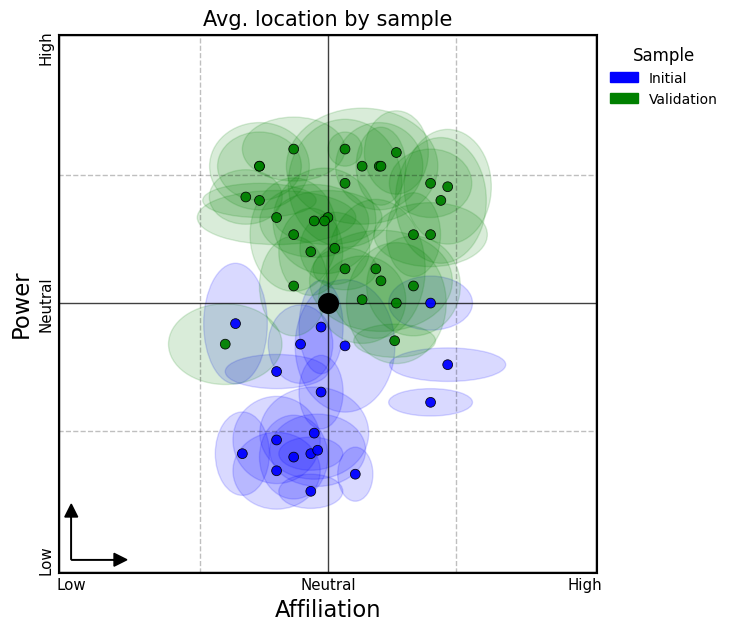

In [19]:
%matplotlib inline

# get variation
for dim in ['affil', 'power']:
    dim_data = data[[f'{dim}_mean_{c}' for c in character_roles[:5]]]
    data[f'{dim}_mean_std']   = np.std(dim_data, axis=1)
    data[f'{dim}_mean_range'] = np.max(dim_data, axis=1) - np.min(dim_data, axis=1)

# plot scatterplot of locations
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Avg. location by sample', fontsize=title_fontsize)
sns.scatterplot(ax=ax, x='affil_mean_mean', y='power_mean_mean', hue='sample', data=data, 
                s=50, alpha=0.95, edgecolor=ec, hue_order=samples, palette=sample_colors)
for s, sub_data in data.iterrows():
    sample = sub_data.loc['sample']
    color = sample_dict[sample]['color']
    xy_m = sub_data.loc[['affil_mean_mean', 'power_mean_mean']].values.astype(float)
    xy_s = sub_data.loc[['affil_mean_std', 'power_mean_std']].values.astype(float)
    elps = Ellipse((xy_m[0], xy_m[1]), # middle
                    xy_s[0], xy_s[1], # width, height
                    color=color, edgecolor=ec, facecolor=color, alpha=0.15, zorder=-1)
    ax.add_patch(elps)
plot_social_space(ax, label_fontsize=label_fontsize*1.25)
add_sample_legend(ax, bbox_to_anchor=(1, 1))
# save_figure(fig, 'Avg-location_by-sample', fig_dir=fig_dir)
plt.show()

# # plot circular histogram of angles
# fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection='polar')) 
# ax.set_title('Avg. neutral angle by sample', fontsize=title_fontsize)
# angles = data['neu_2d_angle_mean'] # radians
# n, bins, patches = circular_hist(ax, angles[data['sample'] == 'Initial'], color=sample_colors[0])
# n, bins, patches = circular_hist(ax, angles[data['sample'] == 'Validation'], color=sample_colors[1])
# add_sample_legend(ax, bbox_to_anchor=(1, 1))
# # save_figure(fig, 'Avg-location_by-sample_circular-hist', fig_dir=fig_dir)
# plt.tight_layout()


# character-wise
# fig, ax = plt.subplots(figsize=(7, 7))
# plot_social_space(ax, label_fontsize=label_fontsize*1.25)
# for char in character_roles:
#     sns.scatterplot(ax=ax, x=f'affil_mean_{char}', y=f'power_mean_{char}', data=data, 
#                     s=50, alpha=0.95, edgecolor=ec, palette=sample_colors)
# plt.show()

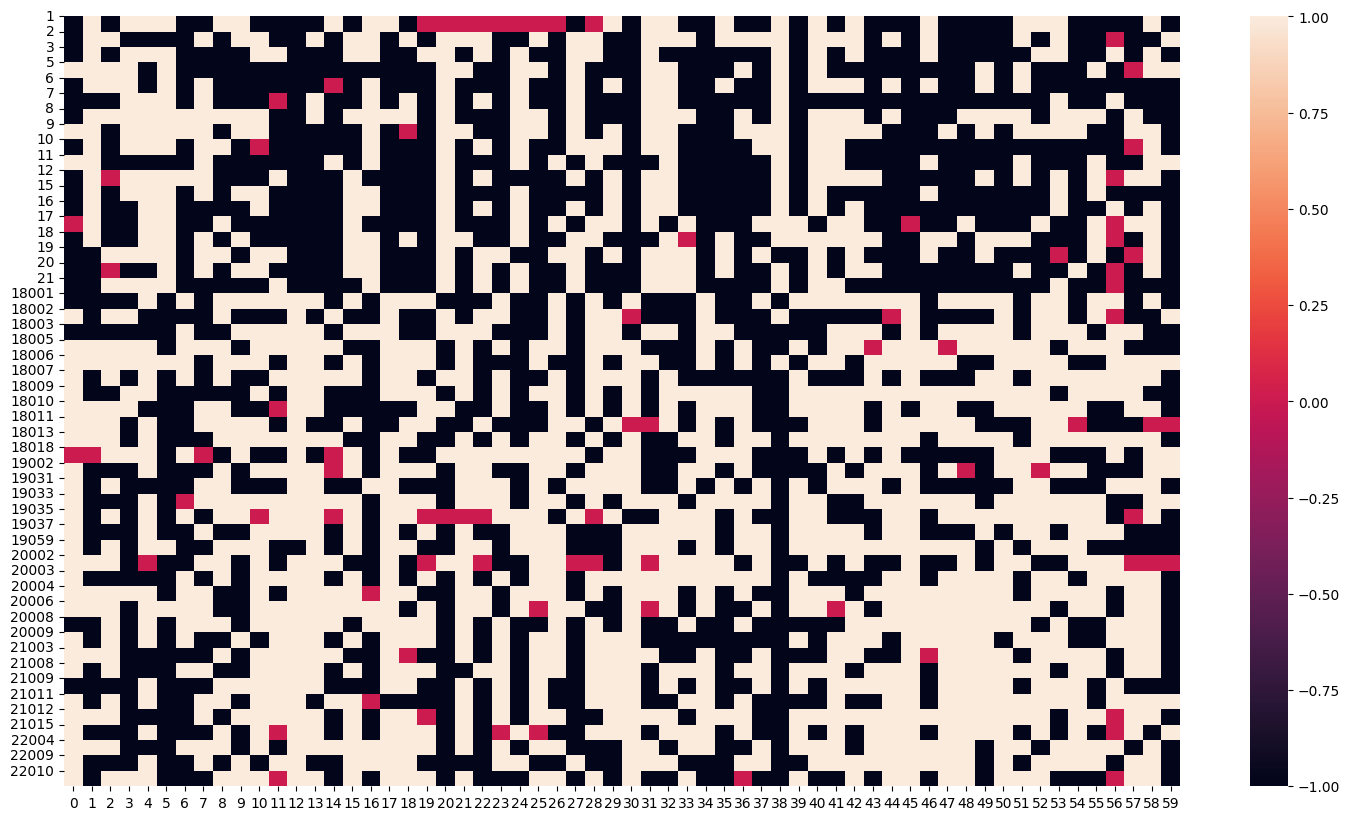

In [61]:
def count_matches(df):
    return df.duplicated(keep=False).sum()
decision_data = data[[f'decision_{t:02d}' for t in np.arange(1,64)]]
print(count_matches(decision_data)) # do any subjects have the same set of decisions?

# plot heatmap of decisions
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
sns.heatmap(remove_neutrals(decision_data.T).T, ax=ax)
ax.set_yticks(np.arange(len(data['sub_id'])), data['sub_id'], rotation=0)
# ax.set_xticks(np.arange(60), data['sub_id'], rotation=0)
# change y tick labels to be sub_id from data
# ax.set_yticklabels(data['sub_id'])
plt.show()

In [52]:
# would want > 0.05 to suggest that the distirbution is not non-uniform
from pycircstat.tests import rayleigh
from astropy.stats import rayleightest
print(rayleigh(data['neu_2d_angle_mean'])) # p-value, r-value
# print(rayleightest(data['neu_2d_angle_mean'])) # p-value

(0.04507579955298801, 3.082372164820691)


# Affiliation & power are uncorrelated 
Correlation between behavioral dimensions standing in as a proxy for orthogonality...
- if correlated not necessarily the case that the underlying dimensions arent orthogonal in terms of their representaiton
- but if uncorrelated seems less likely that they would be correlated in their representation

### Behavior

In [ ]:
def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

fig,axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
for r,role in enumerate(character_roles[:5]):

    affil = jitter(data[f'affil_mean_{role}'], 0.2)
    power = jitter(data[f'power_mean_{role}'], 0.2)
    lsas  = data['lsas_av_score'].values

    sns.kdeplot(ax=axs[r], x=affil, y=power, palette='Blues', levels=5, fill=False, alpha=.25)
    sns.scatterplot(ax=axs[r], x=affil, y=power, c=lsas, cmap='Purples', s=75, alpha=.75)

    axs[r].set_title(role, fontdict={'fontsize':15})
    axs[r].axvline(x=0, color='black')
    axs[r].axhline(y=0, color='black')
    
    #plot_social_space(axs[r])
    if r == 0: axs[r].set_ylabel('Power', fontdict={'fontsize':18})
    else:      axs[r].set_ylabel('')
    if r == 2: axs[r].set_xlabel('Affiliation', fontdict={'fontsize':18})
    else:      axs[r].set_xlabel('')
plt.tight_layout()

In [ ]:
#------------------------------------------------------------------------------------------
# within participants
#------------------------------------------------------------------------------------------

orthog_df = pd.DataFrame(columns=['dim_r-z', 'dim_rho', 'dim_tau', 'dim_rad'])
for s in range(len(data)):
    affil = data.iloc[s,:][[f'affil_mean_{role}' for role in character_roles[:5]]].values.astype(float)
    power = data.iloc[s,:][[f'power_mean_{role}' for role in character_roles[:5]]].values.astype(float)
    r   = pearsonr(affil, power)[0]
    rho = spearmanr(affil, power)[0]
    tau = kendalltau(affil, power)[0]
    rad = math.acos(1 - cosd(power, affil))
    orthog_df.loc[s,:] = [np.arctanh(r), rho, tau, rad]
orthog_df = orthog_df.astype('float64')
orthog_df.insert(0, 'sub_id', data['sub_id'])

#-----------------------------------------------------
# run stats
#-----------------------------------------------------

print('Correlations between affiliation and power within participants')
p = ttest_1samp(orthog_df['dim_r-z'], popmean=0)[1]
print(f'null H0 of r=0 : p={p:.2f}')
p = wilcoxon(orthog_df['dim_rho'])[1]
print(f'null H0 of rho=0 : p={p:.2f}')
p = wilcoxon(orthog_df['dim_tau'])[1]
print(f'null H0 of tau=0 : p={p:.2f}')

# think I should use a circular stat here...
# degs = np.rad2deg(circ_mean(orthog_df['dim_rad']))
# p = ttest_1samp(orthog_df['dim_rad'], popmean=np.pi/2)[1]
# print(f'null H0 of degrees=90 : p={p:.2f}')

#------------------------------------------------------------------------------------------
# across participants
#------------------------------------------------------------------------------------------

affil_trials = decision_trials[(decision_trials['dimension'] == 'affil')]['decision_num'].values
power_trials = decision_trials[(decision_trials['dimension'] == 'power')]['decision_num'].values

#-----------------------------------------------------
# compute affil & power, excluding non-responses
#-----------------------------------------------------

affil = data[['decision_{:02d}'.format(int(t)) for t in affil_trials]]
affil[affil == 0.0] = np.nan
affil = np.nanmean(affil, 1)
affil = scipy.stats.zscore(affil)

power = data[['decision_{:02d}'.format(int(t)) for t in power_trials]]
power[power == 0.0] = np.nan
power = np.nanmean(power, 1)
power = scipy.stats.zscore(power)

#-----------------------------------------------------
# compute correlations
#-----------------------------------------------------

print('\nCorrelations between affiliation and power across participants')
cos = 1 - cosd(power, affil)
print(f'angle between={np.rad2deg(math.acos(cos)):.2f}')

r, p = pearsonr(power, affil)
print(f'r={r:.2f}, p={p:.2f}')

rho, p = spearmanr(power, affil)
print(f'rho={rho:.2f}, p={p:.2f}')

In [ ]:
run_ols(affil, power)[0]

### Subjective placements

In [9]:
dots_cols = ['first_dots_affil','first_dots_power',
            'second_dots_affil','second_dots_power',
            'powerful_dots_affil','powerful_dots_power',
            'boss_dots_affil','boss_dots_power',
            'assistant_dots_affil','assistant_dots_power']

In [10]:
# import cosine
from scipy.spatial.distance import cosine
val_data = sample_dict['Validation']['data']
orthog_df = pd.DataFrame(columns=['dim_r-z', 'dim_rho', 'dim_tau', 'dim_rad', 'mean_affil', 'mean_power'])
for s in range(len(val_data)):

    affil = val_data.iloc[s,:][[c for c in dots_cols if '_affil' in c]].values.astype(float)
    power = val_data.iloc[s,:][[c for c in dots_cols if '_power' in c]].values.astype(float)

    r,_    = pearsonr(affil, power)
    rho, _ = spearmanr(affil, power)
    tau, _ = kendalltau(affil, power)
    rad = math.acos(1 - cosine(power, affil))

    orthog_df.loc[s, :] = [np.arctanh(r), rho, tau, rad, np.mean(affil), np.mean(power)]
    
orthog_df = orthog_df.astype('float64')
orthog_df.insert(0, 'sub_id', val_data['sub_id'])

#----------------------------------------------
# run stats
#----------------------------------------------

t, p = scipy.stats.ttest_1samp(orthog_df['dim_r-z'], popmean=0)
print(f'null H0 of r=0 : p={p:.2f}')

r, p = scipy.stats.pearsonr(orthog_df['mean_affil'], orthog_df['mean_power'])
print(f'r={r:.2f}, p={p:.2f}')

null H0 of r=0 : p=0.57
r=-0.24, p=0.18


# Participants subjectively represent 2D structure of interaction
### Mapping mismatch is smaller than chance & correlates with memory

,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
0,t-test,against 0,x1,31.0,0.0,95.28,93.82,-0.581154,0.182452,-0.953268,-0.20904,-3.185237,0.003289,0.001644,0.998356


,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
0,Intercept + beh_dots_dist_mean,memory_mean_main,Intercept,30.0,0.111,-0.41,-3.34,0.536250,0.039392,0.455801,0.616699,13.613170,2.242705e-14,1.00000,1.121352e-14
1,Intercept + beh_dots_dist_mean,memory_mean_main,beh_dots_dist_mean,30.0,0.111,-0.41,-3.34,-0.086799,0.039392,-0.167248,-0.006350,-2.203465,3.537946e-02,0.01769,9.823103e-01


r=-0.37, p=0.0177
tau=-0.26, p=0.0202


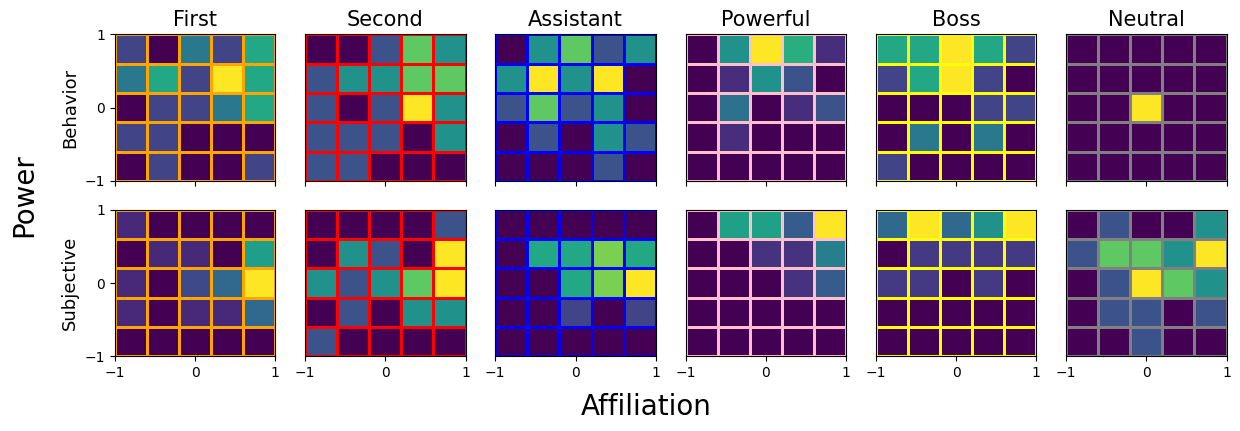

In [62]:
#------------------------------------------------------------------------------------------
# plot the dots & behavior mappings
#------------------------------------------------------------------------------------------

dots_cols = [i for s in [[f'{char}_dots_affil', f'{char}_dots_power'] for char in character_roles] for i in s]
val_data  = sample_dict['Validation']['data']

nrows = 2
fig, axs = plt.subplots(nrows, 6, figsize=(12, 2*nrows), sharex=True, sharey=True)
fig.subplots_adjust(top=0.95)
fig.text(0.5, -0.05, 'Affiliation', ha='center', fontsize=title_fontsize+5)
fig.text(-0.03, 0.5, 'Power', va='center', rotation='vertical', fontsize=title_fontsize+5)

norm_binedges = np.array([-1,-.6,-.2,.2,.6,1]) 
for c, char in enumerate(character_roles):
    
    axs[0,c].set_title(character_roles[c].capitalize(), fontsize=title_fontsize)

    task_affil, task_power = val_data[f'affil_mean_{char}'], val_data[f'power_mean_{char}']
    axs[0,c].hist2d(task_affil, task_power, bins=[norm_binedges, norm_binedges], color=character_colors[c])
    axs[0,c].set_ylabel('Behavior', fontsize=label_fontsize)
    axs[0,c].set_yticks([-1,0,1])
    axs[0,c].set_xticks([-1,0,1])

    dots_power, dots_affil = val_data[f'{char}_dots_power'], val_data[f'{char}_dots_affil']
    axs[1,c].hist2d(dots_affil, dots_power, bins=[norm_binedges, norm_binedges], color=character_colors[c])
    axs[1,c].set_ylabel('Subjective', fontsize=label_fontsize)
    axs[1,c].set_yticks([-1,0,1])
    axs[1,c].set_xticks([-1,0,1])

    if c > 0: [axs[r,c].axes.get_yaxis().set_visible(False) for r in np.arange(0,nrows)] 

plt.tight_layout()
# fig.savefig(fig_dir + "/behavior_dots.png", dpi=150)
# plt.show()

#------------------------------------------------------------------------------------------
# mapping error stats
#------------------------------------------------------------------------------------------

data_ = sample_dict['Validation']['data']
diffs = (data_['beh_dots_dist_mean'] - data_['beh_dots_dist_shuff_mean']) 
zscores = diffs / data_['beh_dots_dist_shuff_std']
data_['beh_dots_dist_zscore'] = zscores

# t-test of mapping error (z-scored wrt permutation) against 0
display(run_ols(zscores, covariates=None)[0])

# correlation of mapping error w/ memory
display(run_ols(X='beh_dots_dist_mean', y='memory_mean_main', covariates=None, data=data_)[0])

r, p = scipy.stats.pearsonr(data_['beh_dots_dist_mean'], data_['memory_mean_main'])
print(f'r={r:.2f}, p={p/2:.4f}')
tau, p = scipy.stats.kendalltau(data_['beh_dots_dist_mean'], data_['memory_mean_main'])
print(f'tau={tau:.2f}, p={p/2:.4f}')



# Mapping plot

In [13]:
data_ = data[np.isfinite(data['beh_dots_dist_diff_memory_tau'])]
data_ = data[data['memory_mean_main'] > 0]
print(f'n={data_.shape[0]}')

n=32


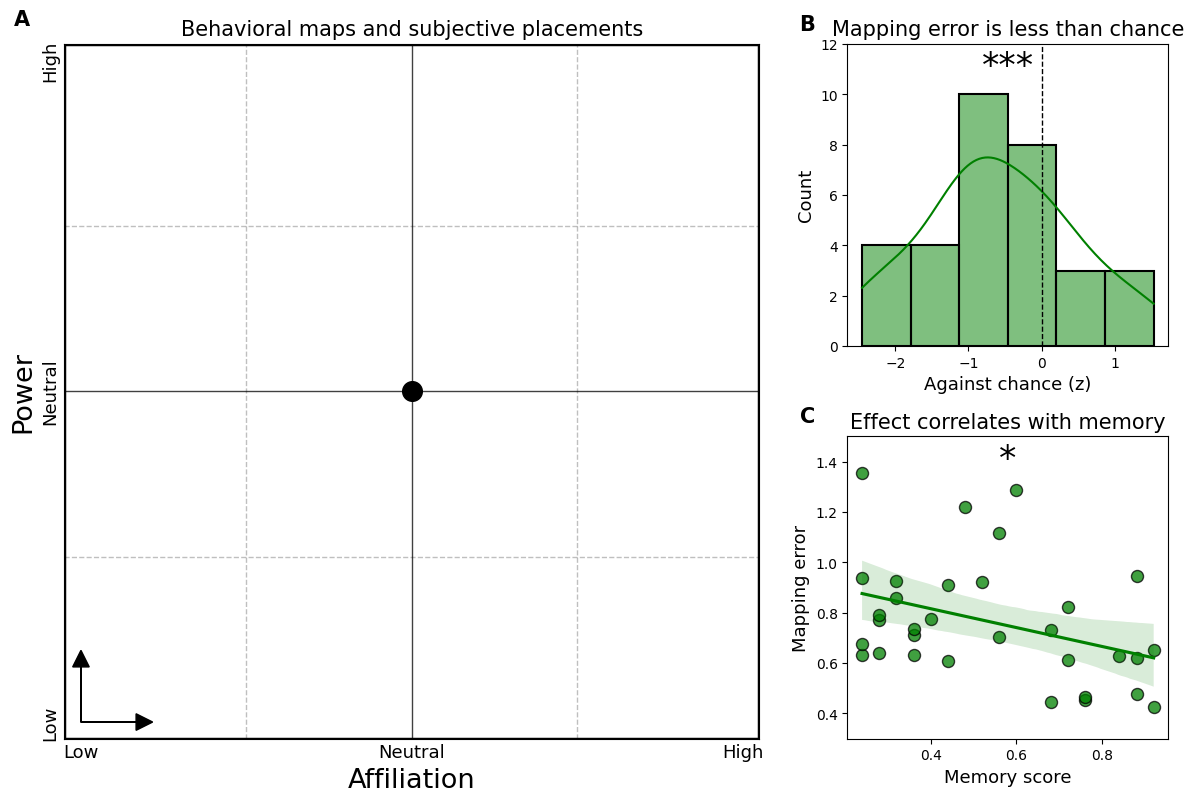

In [17]:
fig, axs = create_subplots((2, 3), {(0,0): (2,2)}, figsize=(12, 8), annotate=False)

# fig.suptitle('Behavioral geometry is consistent with subjective social mapping', fontsize=suptitle_fontsize, y=1.02)

# A: soical space mapping validatio idea
ax = axs[0]
add_subfig_letter(ax, 'A', y=1.05, fontsize=title_fontsize)
ax.set_title('Behavioral maps and subjective placements', fontsize=title_fontsize)
plot_social_space(ax, label_fontsize=label_fontsize*1.5)

# B: permutation: expect smaller distaces than permutation
ax = axs[1]
add_subfig_letter(ax, 'B', x=-0.1, fontsize=title_fontsize)
ax.set_title('Mapping error is less than chance', fontsize=title_fontsize)
plot_histplot(data_['beh_dots_dist_zscore'], ax=ax, color=sample_dict['Validation']['color'])
ax.axvline(0, color='k', linestyle='--', linewidth=1)
ax.set_ylabel('Count', fontsize=label_fontsize)
ax.set_xlabel('Against chance (z)', fontsize=label_fontsize)
add_pval(3, ax)
ax.set_ylim(0,12)

# C: correlation w/ memory: expect more distance between dots & behavior to correlate w/ worse memory
ax = axs[2]
add_subfig_letter(ax, 'C', x=-0.1, fontsize=title_fontsize)
ax.set_title('Effect correlates with memory', fontsize=title_fontsize)
plot_regplot(x=data_['memory_mean_main'], y=data_['beh_dots_dist_mean'], 
             ci=95,
             color=sample_dict['Validation']['color'], ax=ax)
ax.set_ylabel('Mapping error', fontsize=label_fontsize)
ax.set_xlabel('Memory score', fontsize=label_fontsize)
add_pval(1, ax)
ax.set_ylim(0.3, 1.5)
plt.tight_layout()

save_figure(fig, f'{fig_dir}/fig-2_behavioral-validation')

# EXPLORATION

### Are there dimension specific effects?
on average, participants placed characters as being more affiliated with themselves than the game location... hard to interpret but all subjs seem in same direction...

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(21, 3))
for r, role in enumerate(character_roles + ['mean']):
    ax = axs[r]
    sns.scatterplot(x=f'beh_dots_affil_diff_{role}', y=f'beh_dots_power_diff_{role}', data=data, ax=ax,
                    s=100, color='k', alpha=0.5)
    ax.set_xlim(-2.15, 2.15)
    ax.set_ylim(-2.15, 2.15)
    ax.axhline(0, color='k', alpha=0.5, zorder=-1)
    ax.axvline(0, color='k', alpha=0.5, zorder=-1)
    ax.set_xlabel('Affiliation diff. (beh - dots)')
    ax.set_ylabel('Power diff. (beh - dots)')
    ax.set_title(role)
plt.tight_layout()

In [ ]:
# difference from 0 ...
for dim in ['affil', 'power']:
    values = data[f'beh_dots_{dim}_diff_mean'].values
    t, p = scipy.stats.ttest_1samp(values[~np.isnan(values)], popmean=0)
    print(f'{dim} diff mean: t = {t:.2f}, p = {p:.5f}')

In [ ]:
data_ = sample_dict['Validation']['data']
for dim in ['affil', 'power']:
    char_cols = flatten_lists([[f'{role}_dots_{dim}'] for role in character_roles[:5]])
    dots_  = np.mean(data_[char_cols], axis=1)
    behav_ = data_[f'{dim}_mean_mean']
    display(run_ols(dots_, behav_)[0])
    plot_regplot(dots_, behav_)
    plt.show()

### Are there sequence-related effects?

#### Do earlier or later locations inform dots more?

In [ ]:
data_ = sample_dict['Validation']['data']
behav_trajs = get_behav_trajectories(data_)
dots_xys    = get_coords(data_, which='dots')

behav_begin_xys = behav_trajs[:, :, 0, :]
behav_mid_xys   = behav_trajs[:, :, 5, :]
behav_end_xys   = behav_trajs[:, :, -1, :]

dists = []
for behav_xys in [behav_begin_xys, behav_mid_xys, behav_end_xys]:
    dists.append([np.mean(norm(behav_xys[s]/6 - dots_xys[s], axis=1)) for s in range(len(data_))])
dists_df = pd.DataFrame(np.array(dists).T, columns=['begin', 'mid', 'end'])

fig, ax = plt.subplots(figsize=(5,3))
sns.histplot(dists_df, kde=True, alpha=0.25, bins=12)
plt.show()

#### Does trajectory or end location similarity better explain dots similarity, across Ps?
Neither one correlates well in an RSA framework...

Maybe can ask something about IS-RSA here?

In [ ]:
data_     = sample_dict['Validation']['data']

dots_locs     = get_coords(data_, which='dots')
dots_loc_rdvs = [symm_mat_to_ut_vec(pairwise_distances(dl, metric='euclidean')) for dl in dots_locs]

beh_locs     = get_coords(data_)
beh_loc_rdvs = [symm_mat_to_ut_vec(pairwise_distances(bl, metric='euclidean')) for bl in beh_locs]

beh_trajs     = get_behav_trajectories(data_)
beh_traj_rdvs = [symm_mat_to_ut_vec(pairwise_trajectory_distances(bt, metric='frechet')) for bt in beh_trajs] # frechet,  hausdorff, or dtw


In [ ]:
loc_taus  = [kendalltau(dots_loc_rdvs[i], beh_loc_rdvs[i])[0] for i in range(len(data_))]
W, p = scipy.stats.wilcoxon(loc_taus, alternative='greater')
print(f'Location: W = {W:.2f}, p = {p:.5f}')

traj_taus = [kendalltau(dots_loc_rdvs[i], beh_traj_rdvs[i])[0] for i in range(len(data_))]
W, p = scipy.stats.wilcoxon(traj_taus, alternative='greater')
print(f'Trajectory: W = {W:.2f}, p = {p:.5f}')

# Comparing affil v. power

In [ ]:
affil_greater = data['affil_mean_mean'] > data['power_mean_mean']
power_greater = data['power_mean_mean'] > data['affil_mean_mean']

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(x=data['affil_mean_mean'][affil_greater], y=data['power_mean_mean'][affil_greater], 
           edgecolor=ec, linewidth=lw, color='blue', alpha=1)
ax.scatter(x=data['affil_mean_mean'][power_greater], y=data['power_mean_mean'][power_greater], 
           edgecolor=ec, linewidth=lw, color='red', alpha=1)
plot_social_space(ax)
ax.plot([-1, 1], [-1, 1], color='k', linestyle='--', alpha=0.5, zorder=-1)
plt.show()


### Number of unique locations, at different spatial resolutions

# Trajectories

problem with comparing full trajectories w/in participant is some of element-wise similarity is constrained by the task... 

probably would need to normalize by the min and max possible trajectory similarity to standardize the comparisons

comparing overall within participant trajectory similiarty is fine though since all participants get the same constraints

BUT: there are probably more ways to produce highly convoluted sequences (and trajectories closer to the origin) than to create trajectories that span out into the space...
- so counterintuitively, more consistency --> more likely to be more varied trajectories in space

In [ ]:
beh_trajs = get_behav_trajectories()
beh_traj_rdvs = [symm_mat_to_ut_vec(pairwise_trajectory_distances(bt, metric='frechet')) for bt in beh_trajs] # frechet, hausdorff, or dtw
beh_traj_dist = [np.mean(x) for x in beh_traj_rdvs] # average distance/dissimilarity between relationships
data['beh_traj_dist'] = beh_traj_dist

In [ ]:
mask = np.isfinite(data['sni_num_ppl'])
size_var = 'beh_traj_dist'
display(run_ols(size_var, 'sni_num_ppl', data, covariates=demo_controls)[0])
plot_regplot(data[size_var][mask], data['sni_num_ppl'][mask])
plt.show()

# Correlations w/ self-reports etc

In [ ]:
data_ = data[['pov_2d_dist_mean', 'volume',
              'affil_mean_mean', 'power_mean_mean', # beh
              'dots_affil_mean', 'dots_power_mean', # dots
              'beh_dots_dist_mean',
              'memory_mean_main', 
              'age_years', 'lsas_av_score2', 'sni_num_ppl', 'sni_network_div', 'sni_num_close_friends', 'ctq_score']]
cm = data_.corr()
cm = cm[np.abs(cm) > 0.30]
sns.heatmap(cm, cmap='RdBu_r', vmin=-1, vmax=1, center=0)
plt.show()

In [ ]:
models = [['pov_2d_dist_mean', 'pov_2d_angle_mean'], 
          ['affil_mean_mean', 'power_mean_mean'],
           ['affil_mean_mean', 'power_mean_mean', 'dots_affil_mean', 'dots_power_mean']]
for model in models:
    display(run_ols(X=model, y='beh_dots_dist_mean', data=data, covariates=demo_controls)[0])

In [ ]:
#what drives the disparity?

# plot beh_dots_dist_mean against pov_2d_dist_mean
fig, axs = plt.subplots(2, 2, figsize=(5,5), sharey=True)
ax = axs[0, 0]
sns.regplot(x='affil_mean_mean', y='beh_dots_dist_mean', data=data_, 
            color=sample_dict['Validation']['color'],
            scatter_kws={'alpha': 1, 's': 50, 'edgecolor': ec, 'linewidth': lw},
            ax=ax)
ax.set_ylabel('Mapping mismatch')
ax.set_xlabel('Affil (beh)')

ax = axs[0, 1]
sns.regplot(x='dots_affil_mean', y='beh_dots_dist_mean', data=data_,
            color=sample_dict['Validation']['color'],
            scatter_kws={'alpha': 1, 's': 50, 'edgecolor': ec, 'linewidth': lw},
            ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Affil (dots)')

ax = axs[1, 0]
sns.regplot(x='power_mean_mean', y='beh_dots_dist_mean', data=data_, 
            color=sample_dict['Validation']['color'],
            scatter_kws={'alpha': 1, 's': 50, 'edgecolor': ec, 'linewidth': lw},
            ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Power (beh)')
ax.set_ylabel('Mapping mismatch')

ax = axs[1, 1]
sns.regplot(x='dots_power_mean', y='beh_dots_dist_mean', data=data_,
            color=sample_dict['Validation']['color'],
            scatter_kws={'alpha': 1, 's': 50, 'edgecolor': ec, 'linewidth': lw},
            ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Power (dots)')
plt.tight_layout()
plt.show()
# ax.set_title(f'Correlation: r = {r:.2f}, p = {p/2:.3f}')